Because of several problems training the model, we want to know what where the problem can be found, by looking at datatype for each column.  

In [30]:
import pandas as pd

# Load the dataset
df = pd.read_csv('features_dataset.csv')

# Print data types for each column
print(df.dtypes)

label                    int64
TTR                    float64
text_polarity          float64
text_subjectivity      float64
title_polarity         float64
title_subjectivity     float64
doc_perplexity         float64
1_grams                 object
average_word_length    float64
dtype: object


it can be identified from the code above, that '1_grams' column are object datatype which means it include letters. Therefore we need to vectorize the column to "float", which means it convert letters to numbers

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the vectorizer
vectorizer = CountVectorizer()

# Vectorize the text data directly
X_vectorized = vectorizer.fit_transform(df['1_grams'])


# Drop the non-numeric column and convert DataFrame to a sparse DataFrame to concatenate with X_vectorized
df_dropped = df.drop('1_grams', axis=1).astype(float)  # Convert other columns to float
from scipy.sparse import csr_matrix, hstack
df_dropped_sparse = csr_matrix(df_dropped.values)  # Convert DataFrame to sparse matrix
X_final = hstack([df_dropped_sparse, X_vectorized])  # Concatenate the matrices



In [32]:

# Function to safely convert columns to numeric and check for negative values
def check_negatives(dataframe):
    negative_counts = {}
    for column in dataframe.columns:
        # Convert column to numeric, non-convertible values become NaN
        converted_column = pd.to_numeric(dataframe[column], errors='coerce')
        # Count negative values
        count = (converted_column < 0).sum()
        if count > 0:
            negative_counts[column] = count
    return negative_counts

# Apply the function to your DataFrame
negative_columns = check_negatives(df)

# Print the columns with negative values and their counts
print("Columns with negative values and their counts:")
for column, count in negative_columns.items():
    print(f"{column}: {count} negatives")


Columns with negative values and their counts:
text_polarity: 3097 negatives
title_polarity: 3117 negatives


In [33]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Load the dataset
df = pd.read_csv('features_dataset.csv')  # Adjust the path as necessary

# Convert all columns to numeric, handling non-numeric gracefully
df = df.apply(pd.to_numeric, errors='coerce')

# Fill NaN values that result from conversion errors
df.fillna(0, inplace=True)

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the data to scale each feature to [0, 1] range
df_scaled = scaler.fit_transform(df.drop('label', axis=1))

# Split the data into features and target
X = df_scaled
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Multinomial Naive Bayes classifier
model = MultinomialNB()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", report)


Accuracy: 0.6176364293458619
Confusion Matrix:
 [[954 399]
 [659 755]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.71      0.64      1353
           1       0.65      0.53      0.59      1414

    accuracy                           0.62      2767
   macro avg       0.62      0.62      0.62      2767
weighted avg       0.62      0.62      0.62      2767



lets try to optimize the model using GridSearchCV

In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score: {:.2f}".format(grid_search.best_score_))

# Evaluate using the best parameters
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.72
Test Accuracy: 0.7217202746657029
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.78      0.73      1353
           1       0.76      0.67      0.71      1414

    accuracy                           0.72      2767
   macro avg       0.73      0.72      0.72      2767
weighted avg       0.73      0.72      0.72      2767



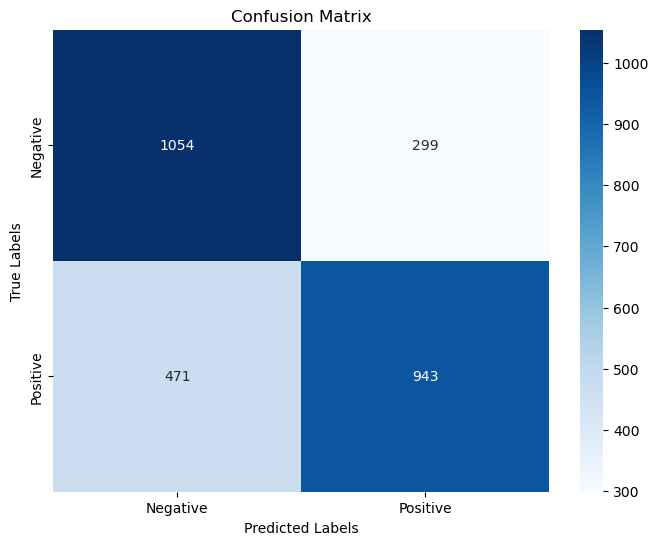

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
